In [1]:
#Notes:
#This is the HTML file with all my code and what it outputs.
#THIS CODE WILL NOT RUN

In [2]:
#These import packages I need
import pandas as pd
import numpy as np
#This reads the combined (Google and NY Times) dataset
dataset=pd.read_csv("indiana3mo.csv")
#this converts the date to the correct type
dataset['date'] = pd.to_datetime(dataset['date'], format='%m/%d/%Y')
dataset['date2']=dataset['date']
#this makes all the dates into weeks
dataset['week']=dataset['date'].dt.to_period('W-Fri')
#This takes the weekly average of many different area that people go to and the min and max number of cases for the week 
dataset=dataset.groupby(['full_name', 'week']).agg(retail_avg=('retail_and_recreation_percent_change_from_baseline','mean'),
                                                    grocery_avg=('grocery_and_pharmacy_percent_change_from_baseline','mean'),
                                                    parks_avg=('parks_percent_change_from_baseline','mean'),
                                                    transit_avg=('transit_stations_percent_change_from_baseline','mean'),
                                                    workplace_avg=('workplaces_percent_change_from_baseline','mean'), 
                                                    residential_avg=('residential_percent_change_from_baseline','mean'),
                                                    cases_max=('cases','max'), 
                                                    deaths_max=('deaths','max'),
                                                    cases_min=('cases','min'),
                                                    deaths_min=('deaths','min'),
                                                    week_of_date=('date2', 'min'))
#calculate new cases and new deaths
dataset['cases_change'] = dataset['cases_max']-dataset['cases_min']
dataset['deaths_change']= dataset['deaths_max']-dataset['deaths_min']
dataset=dataset.reset_index()
#set the index of the dataset
dataset=dataset.set_index(["full_name", "week_of_date"])
#display the dataset
dataset


week  retail_avg  grocery_avg  \
full_name       week_of_date                                                   
Adams Indiana   2020-05-01    2020-04-25/2020-05-01  -20.000000          NaN   
                2020-05-02    2020-05-02/2020-05-08  -13.000000          NaN   
                2020-05-09    2020-05-09/2020-05-15  -11.333333    -7.000000   
                2020-05-16    2020-05-16/2020-05-22   -5.857143     3.000000   
                2020-05-23    2020-05-23/2020-05-29   -6.000000     9.000000   
...                                             ...         ...          ...   
Whitley Indiana 2020-06-27    2020-06-27/2020-07-03   14.857143    16.000000   
                2020-07-04    2020-07-04/2020-07-10    8.000000     7.000000   
                2020-07-11    2020-07-11/2020-07-17   12.857143     7.166667   
                2020-07-18    2020-07-18/2020-07-24    6.714286     3.400000   
                2020-07-25    2020-07-25/2020-07-31    9.000000     2.500000   

                              parks_avg  transit_avg  workplace_avg  \
full_name       week_of_date                                          
Adams Indiana   2020-05-01          NaN          NaN     -32.000000   
                2020-05-02          NaN          NaN     -23.571429   
                2020-05-09          NaN          NaN     -19.142857   
                2020-05-16          NaN          NaN     -19.714286   
                2020-05-23          NaN          NaN     -24.428571   
...                                 ...          ...            ...   
Whitley Indiana 2020-06-27          NaN          NaN     -28.428571   
                2020-07-04          NaN          NaN     -25.285714   
                2020-07-11          NaN          NaN     -18.857143   
                2020-07-18          NaN          NaN     -19.857143   
                2020-07-25          NaN          NaN     -19.714286   

                              residential_avg  cases_max  deaths_max  \
full_name       week_of_date                                           
Adams Indiana   2020-05-01                NaN          7           1   
                2020-05-02                NaN          9           1   
                2020-05-09           9.333333          9           1   
                2020-05-16           9.000000         11           1   
                2020-05-23           6.666667         13           1   
...                                       ...        ...         ...   
Whitley Indiana 2020-06-27           6.500000        235           6   
                2020-07-04           7.200000        248           6   
                2020-07-11           6.200000        271           6   
                2020-07-18           6.600000        281           6   
                2020-07-25           6.600000        304           6   

                              cases_min  deaths_min  cases_change  \
full_name       week_of_date                                        
Adams Indiana   2020-05-01            7           1             0   
                2020-05-02            8           1             1   
                2020-05-09            8           1             1   
                2020-05-16            9           1             2   
                2020-05-23           12           1             1   
...                                 ...         ...           ...   
Whitley Indiana 2020-06-27          211           5            24   
                2020-07-04          237           5            11   
                2020-07-11          248           6            23   
                2020-07-18          270           6            11   
                2020-07-25          281           6            23   

                              deaths_change  
full_name       week_of_date                 
Adams Indiana   2020-05-01                0  
                2020-05-02                0  
                2020-05-09                0  
                2

In [3]:
dates = dataset.index.get_level_values('week_of_date').to_list()
dataset['week_of_date'] = pd.Categorical(dates)

In [4]:
#imports needed for graphing
from linearmodels import PooledOLS
import statsmodels.api as sm
exog = sm.tools.tools.add_constant(dataset['workplace_avg'])
endog = dataset['deaths_change']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

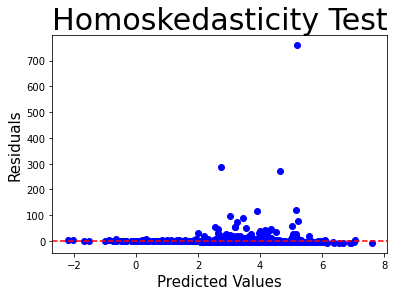

In [5]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
# 3A.1 Graph to check for Homoskedasticity 
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = "blue")
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [6]:
# White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(['week_of_date'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(dataset['workplace_avg']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print("White test: ")
print(dict(zip(labels, white_test_results)))
print("")
# Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print('Breusch-Pagan Test:')
print(dict(zip(labels, breusch_pagan_test_results)))

White test: 
{'LM-Stat': 2.7229696141778943, 'LM p-val': 0.2562799679963627, 'F-Stat': 1.3611913507737394, 'F p-val': 0.25672456925027054}

Breusch-Pagan Test:
{'LM-Stat': 1.9680635383564873, 'LM p-val': 0.1606535565383541, 'F-Stat': 1.9680146647757897, 'F p-val': 0.1609001252214411}


In [7]:
# Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print('Durbin-Watson test: ')
print(durbin_watson_test_results)

Durbin-Watson test: 
1.9293335482525946


In [8]:
# RE model
#imports needed packages for modeling
from linearmodels import PanelOLS
from linearmodels import RandomEffects
#independent variable
exog = sm.tools.tools.add_constant(dataset['workplace_avg'])
#dependent variable
endog = dataset['deaths_change']
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
#print model
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:          deaths_change   R-squared:                        0.0032
Estimator:              RandomEffects   R-squared (Between):             -0.0072
No. Observations:                1288   R-squared (Within):               0.0040
Date:                Mon, Mar 08 2021   R-squared (Overall):              0.0027
Time:                        20:48:07   Log-likelihood                   -5974.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4.1264
Entities:                          92   P-value                           0.0424
Avg Obs:                       14.000   Distribution:                  F(1,1286)
Min Obs:                       14.000                                           
Max Obs:                       14.000   F-statistic (robust):             4.1264
                            